In [1]:
#!/usr/bin/env python
''' Conditioned_Data.ipynb

    This program reads in CONUS404 10 hourly wind speed and finds cold-pool gust fronts.
    It then reads in reflectivity, DCAPE, CAPE, and Cold Pool Intensity conditions that
    are associated with the wind.

'''

from scipy import stats
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import glob
import os
from pdb import set_trace as stop
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import median_filter
from scipy.ndimage import label
from matplotlib import cm
from scipy import ndimage
import random
import scipy
import pickle
from datetime import timedelta
import datetime
import pandas as pd
import subprocess
from calendar import monthrange
import shapefile as shp
import matplotlib.path as mplPath
from thermodynamics_p3 import Theta
import netCDF4

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr
import sys
from tqdm import tqdm

import matplotlib.gridspec as gridspec
import seaborn as sns

### USER SETUP SECTION

In [2]:
YYYY = 2010 #int(sys.argv[1])
# MM = 7 #int(sys.argv[2])
from calendar import monthrange
# MonthDays = monthrange(YYYY, MM)[1]

TimeHH = pd.date_range(datetime.datetime(YYYY, 6, 1,0), end=datetime.datetime(YYYY, 8, 31,23), freq='h')
TimeMM = pd.date_range(datetime.datetime(YYYY, 6, 1,0), end=datetime.datetime(YYYY, 9, 1,23), freq='m')
    
# WRF
WRFdir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/' 

lon_start = 624 - 2
lon_stop = 980 + 2
lat_start = 359 - 2
lat_stop = 707 + 2

out_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/conditioned_data/'
save_dir = '/glade/campaign/mmm/c3we/prein/CONUS404/data/Wind_analyis/derived_data/conditional_data/'

In [3]:
ncid=Dataset('/glade/campaign/mmm/c3we/prein/CONUS404/data/MonthlyData/wrfout_conus404_constants.nc', mode='r')
lon_wrf=np.squeeze(ncid.variables['XLONG'][:,lat_start:lat_stop,lon_start:lon_stop])
lat_wrf=np.squeeze(ncid.variables['XLAT'][:,lat_start:lat_stop,lon_start:lon_stop])
ncid.close()

lon_wrf[lon_wrf > 180] = lon_wrf[lon_wrf > 180]-360

from Tracking_Functions import calc_grid_distance_area
_,_,Area,Gridspacing = calc_grid_distance_area(lat_wrf,lon_wrf)
Area[Area < 0] = 0

### Get Central U.S. region

In [4]:
### regions in C-404 grid
import geopandas as gpd
REGIONS = ['Central_US.shp'] #['Gulf-Atlantic_coast.shp','Westcoast.shp','Front-Range.shp', 'Intermauntain-west.shp','Central_US.shp']#'Derecho_hotspot.shp'] #'Midwest.shp',
reg_colors = ['#1f78b4','#33a02c','#e31a1c','#ff7f00','#6a3d9a','#b2df8a']

wrf_region_masks = np.zeros((lat_wrf.shape[0],lat_wrf.shape[1]))
# rgrGridCells=[(lon_wrf.flatten()[ii],lat_wrf.flatten()[ii]) for ii in range(len(lat_wrf.flatten()))]
rgrGridCells = np.append(lon_wrf.flatten()[:,None],lat_wrf.flatten()[:,None], axis=1)
for re in tqdm(range(len(REGIONS))):
    data = gpd.read_file('/glade/u/home/prein/papers/2022_Wind-Changes/shapefiles/'+REGIONS[re])
    Coordinates = data['geometry']
    sf = 0
    TEST = np.array(Coordinates[sf].exterior.coords.xy)
    ctr=TEST.T
    grPRregion=mplPath.Path(ctr)
    TMP=np.array(grPRregion.contains_points(rgrGridCells))
    TMP = np.reshape(TMP, (lat_wrf.shape[0], lat_wrf.shape[1]))
    wrf_region_masks[TMP==1] = re+1
#     MaskStations = np.append(MaskStations,[re+1]*len(iStationSelect))
wrf_region_masks = wrf_region_masks.astype('int')
    
wrf_region_masks[wrf_region_masks < 0] = 0

100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


### Read the WRF data

In [5]:
for mm in tqdm(range(len(TimeMM))):
    MM = TimeMM[mm].month
    
    file = WRFdir + 'U10/U10_' + str(YYYY) + str(MM).zfill(2) + '_CONUS404.nc'
    DATA = xr.open_dataset(file)
    u10 = DATA['U10'][:,lat_start:lat_stop,lon_start:lon_stop].values

    file = WRFdir + 'V10/V10_' + str(YYYY) + str(MM).zfill(2) + '_CONUS404.nc'
    DATA = xr.open_dataset(file)
    v10 = DATA['V10'][:,lat_start:lat_stop,lon_start:lon_stop].values

    uv10_tmp = (u10**2 + v10**2)**0.5
    if mm == 0:
        uv10 = uv10_tmp
    else:
        uv10 = np.append(uv10, uv10_tmp, axis=0)

    file = WRFdir + 'cold_pool_intensity/' + str(YYYY) + str(MM).zfill(2) + '_Cold-Pool-Intensity.nc'
    DATA = xr.open_dataset(file)
    cpi_tmp = DATA['coldpoolint'][:,lat_start:lat_stop,lon_start:lon_stop].values
    if mm == 0:
        cpi = cpi_tmp
    else:
        cpi = np.append(cpi, cpi_tmp, axis=0)

    file = WRFdir + 'DCAPE/' + str(YYYY) + str(MM).zfill(2) + '_DCAPE-DCIN.nc'
    DATA = xr.open_dataset(file)
    dcape_tmp = DATA['dcape'][:,lat_start:lat_stop,lon_start:lon_stop].values
    if mm == 0:
        dcape = dcape_tmp
    else:
        dcape = np.append(dcape, dcape_tmp, axis=0)

    file = WRFdir + 'REFL_10CM/REFL_10CM_' + str(YYYY) + str(MM).zfill(2) + '_CONUS404.nc'
    DATA = xr.open_dataset(file)
    dbz_tmp = DATA['REFL_10CM'][:,lat_start:lat_stop,lon_start:lon_stop].values
    if mm == 0:
        dbz = dbz_tmp
    else:
        dbz = np.append(dbz, dbz_tmp, axis=0)

    file = WRFdir + 'T2/T2_' + str(YYYY) + str(MM).zfill(2) + '_CONUS404.nc'
    DATA = xr.open_dataset(file)
    t2_tmp = DATA['T2'][:,lat_start:lat_stop,lon_start:lon_stop].values
    if mm == 0:
        t2 = t2_tmp
    else:
        t2 = np.append(t2, t2_tmp, axis=0)

    file = WRFdir + 'MLCAPE/MLCAPE_' + str(YYYY) + str(MM).zfill(2) + '_CONUS404.nc'
    DATA = xr.open_dataset(file)
    cape_tmp = DATA['MLCAPE'][:,lat_start:lat_stop,lon_start:lon_stop].values
    if mm == 0:
        cape = cape_tmp
    else:
        cape = np.append(cape, cape_tmp, axis=0)

    file = WRFdir + 'LWUPT/LWUPT_' + str(YYYY) + str(MM).zfill(2) + '_CONUS404.nc'
    DATA = xr.open_dataset(file)
    LWUPT = DATA['LWUPT'][:,lat_start:lat_stop,lon_start:lon_stop].values
    Tf = (LWUPT/5.6693e-8)**(1./4.)
    a = -0.000917
    b =  1.13333
    c =  10.50007
    c = c - Tf
    Tb_tmp = (-b+np.sqrt(b**2-4*a*c))/(2.*a)
    if mm == 0:
        Tb = Tb_tmp
    else:
        Tb = np.append(Tb, Tb_tmp, axis=0)
    

100%|██████████| 3/3 [10:32<00:00, 210.73s/it]


In [6]:
### maske out central U.S. region
uv10[:,wrf_region_masks != 1] = np.nan
cpi[:,wrf_region_masks != 1] = np.nan
dcape[:,wrf_region_masks != 1] = np.nan
dbz[:,wrf_region_masks != 1] = np.nan
t2[:,wrf_region_masks != 1] = np.nan
cape[:,wrf_region_masks != 1] = np.nan
Tb[:,wrf_region_masks != 1] = np.nan

In [7]:
# calculate temperature change
t2_dt = t2[1:,:] - t2[:-1,:]
t2_dt = np.append(t2_dt[0,:,:][None,:], t2_dt, axis=0); t2_dt[-1,:] = np.nan

### Calculate statistics

In [8]:
tb_mask = scipy.ndimage.gaussian_filter((Tb[:,:,:] <= 241).astype('float'),(0,5,5)) > 0.01
# get individual cloud features and check if they are convective
rgiObj_Struct = np.zeros((3,3,3)); rgiObj_Struct[1,:,:] = 1
objects_tb, nr_objects_tb = ndimage.label( tb_mask, structure = rgiObj_Struct)
obj_slizes = ndimage.find_objects(objects_tb)
for ob in tqdm(range(nr_objects_tb)):
    tb_obj_sel = objects_tb[obj_slizes[ob]]
    z_obj = dbz[obj_slizes[ob]]
    
    if np.nanmax(z_obj[tb_obj_sel > 0]) < 40:
        tb_obj_sel[tb_obj_sel == ob+1] = 0
    objects_tb[obj_slizes[ob]] = tb_obj_sel

/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.
  0%|          | 0/7254 [00:00<?, ?it/s]/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: All-NaN slice encountered
  # Remove the CWD from sys.path while we load stuff.
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.
100%|██████████| 7254/7254 [00:00<00:00, 26001.42it/s]


In [23]:
# calcualte statistics for each hour
time_delta = [-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10,11,12]
percentiles = np.arange(0,101,1)
focus_area = ['Tb shield', '>40dBZ','>15m/s']
area_types = ['<=241Tb','>=40dBZ','>=10m/s','>=20m/s']
var_name = ['cape','dcape','uv10','cpi','t2_dt','Tb','Z']

var_stats = np.zeros((len(TimeHH),len(time_delta),len(percentiles), len(focus_area), len(var_name))); var_stats[:] = np.nan
# dcape_stats = np.zeros((len(TimeHH),len(time_delta),len(percentiles), len(focus_area))); dcape_stats[:] = np.nan
# uv10_stats = np.zeros((len(TimeHH),len(time_delta),len(percentiles), len(focus_area))); uv10_stats[:] = np.nan
# cpi_stats = np.zeros((len(TimeHH),len(time_delta),len(percentiles), len(focus_area))); cpi_stats[:] = np.nan
# t2_dt_stats = np.zeros((len(TimeHH),len(time_delta),len(percentiles), len(focus_area))); t2_dt_stats[:] = np.nan
# Tb_stats = np.zeros((len(TimeHH),len(time_delta),len(percentiles))); Tb_stats[:] = np.nan

non_convective_UV10 = np.zeros((len(TimeHH),len(time_delta),len(percentiles))); non_convective_UV10[:] = np.nan
area_coverages =  np.zeros((len(TimeHH),len(time_delta),len(area_types))); area_coverages[:] = np.nan

for tt in tqdm(range(len(TimeHH))):
    z_act = np.copy(dbz[tt,:])
    z_act[objects_tb[tt,:] == 0] = np.nan
    z_mask = z_act >= 40
    z_mask = scipy.ndimage.gaussian_filter(z_mask.astype('float'), 3) > 0.1
    
    uv_act = np.copy(uv10[tt,:])
    uv_act[objects_tb[tt,:] == 0] = np.nan
    uv_mask = uv_act >= 15
    uv_mask = scipy.ndimage.gaussian_filter(uv_mask.astype('float'), 3) > 0.1
    for dt in range(len(time_delta)):
        tt_act = tt + time_delta[dt]
        if tt_act < 0:
            tt_act = 0
        if tt_act >= len(TimeHH):
            tt_act = len(TimeHH)-1        
        
        # work on CAPE
        cape_act = np.copy(cape[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('cape')] = np.nanpercentile(cape_act[objects_tb[tt,:] != 0], percentiles)
        var_stats[tt,dt,:,1,var_name.index('cape')] = np.nanpercentile(cape_act[z_mask == 1], percentiles)
        var_stats[tt,dt,:,2,var_name.index('cape')] = np.nanpercentile(cape_act[uv_mask == 1], percentiles)
        
        # work on dcape
        dcape_act = np.copy(dcape[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('dcape')] = np.nanpercentile(dcape_act[objects_tb[tt,:] != 0], percentiles)
        var_stats[tt,dt,:,1,var_name.index('dcape')] = np.nanpercentile(dcape_act[z_mask == 1], percentiles)
        var_stats[tt,dt,:,2,var_name.index('dcape')] = np.nanpercentile(dcape_act[uv_mask == 1], percentiles)

        # work on uv10
        uv10_act = np.copy(uv10[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('uv10')] = np.nanpercentile(uv10_act[objects_tb[tt,:] != 0], percentiles)
        var_stats[tt,dt,:,1,var_name.index('uv10')] = np.nanpercentile(uv10_act[z_mask == 1], percentiles)
        var_stats[tt,dt,:,2,var_name.index('uv10')] = np.nanpercentile(uv10_act[uv_mask == 1], percentiles)

        # work on CPI
        cpi_act = np.copy(cpi[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('cpi')] = np.nanpercentile(cpi_act[objects_tb[tt,:] != 0], percentiles)
        var_stats[tt,dt,:,1,var_name.index('cpi')] = np.nanpercentile(cpi_act[z_mask == 1], percentiles)
        var_stats[tt,dt,:,2,var_name.index('cpi')] = np.nanpercentile(cpi_act[uv_mask == 1], percentiles)
        
        # t2_dt
        t2_dt_act = np.copy(t2_dt[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('t2_dt')] = np.nanpercentile(t2_dt_act[objects_tb[tt,:] != 0], percentiles)
        var_stats[tt,dt,:,1,var_name.index('t2_dt')] = np.nanpercentile(t2_dt_act[z_mask == 1], percentiles)
        var_stats[tt,dt,:,2,var_name.index('t2_dt')] = np.nanpercentile(t2_dt_act[uv_mask == 1], percentiles)
        
        # Z
        z_act = np.copy(dbz[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('Z')] = np.nanpercentile(z_act[objects_tb[tt,:] != 0], percentiles)
        var_stats[tt,dt,:,1,var_name.index('Z')] = np.nanpercentile(z_act[z_mask == 1], percentiles)
        var_stats[tt,dt,:,2,var_name.index('Z')] = np.nanpercentile(z_act[uv_mask == 1], percentiles)

        # Tb_dt
        tb_act = np.copy(Tb[tt_act,:])
        var_stats[tt,dt,:,0,var_name.index('Tb')] = np.nanpercentile(tb_act[tb_act <= 241], percentiles)

        # non convective wind
        uv10_nc_act = np.copy(uv10[tt_act,:])
        non_convective_UV10[tt,dt,:] = np.nanpercentile(uv10_nc_act[objects_tb[tt,:] == 0], percentiles)
        
        # calculate areas
        Tb_act = np.copy(Tb[tt_act,:])
        area_coverages[tt,dt,0] = np.sum(Area[Tb_act <= 241])
        dBz_act = np.copy(dbz[tt_act,:])
        area_coverages[tt,dt,1] = np.sum(Area[dBz_act >= 40])
        area_coverages[tt,dt,2] = np.sum(Area[uv10_act >= 10])
        area_coverages[tt,dt,3] = np.sum(Area[uv10_act >= 20])
        
np.savez(save_dir + str(YYYY) + '-JJA_conditional-data.npz',
        focus_area = focus_area,
        area_types = area_types,
        var_name = var_name,
        TimeMM =TimeMM,
        var_stats = var_stats,
        area_coverages = area_coverages,
        non_convective_UV10 = non_convective_UV10,
        lon_wrf = lon_wrf,
        lat_wrf = lat_wrf,
        wrf_region_masks = wrf_region_masks)

  0%|          | 0/2208 [00:00<?, ?it/s]/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1368: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in less_equal
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in less_equal
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:83: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/pr

Text(0.5, 1.0, 'non-conv. UV10')

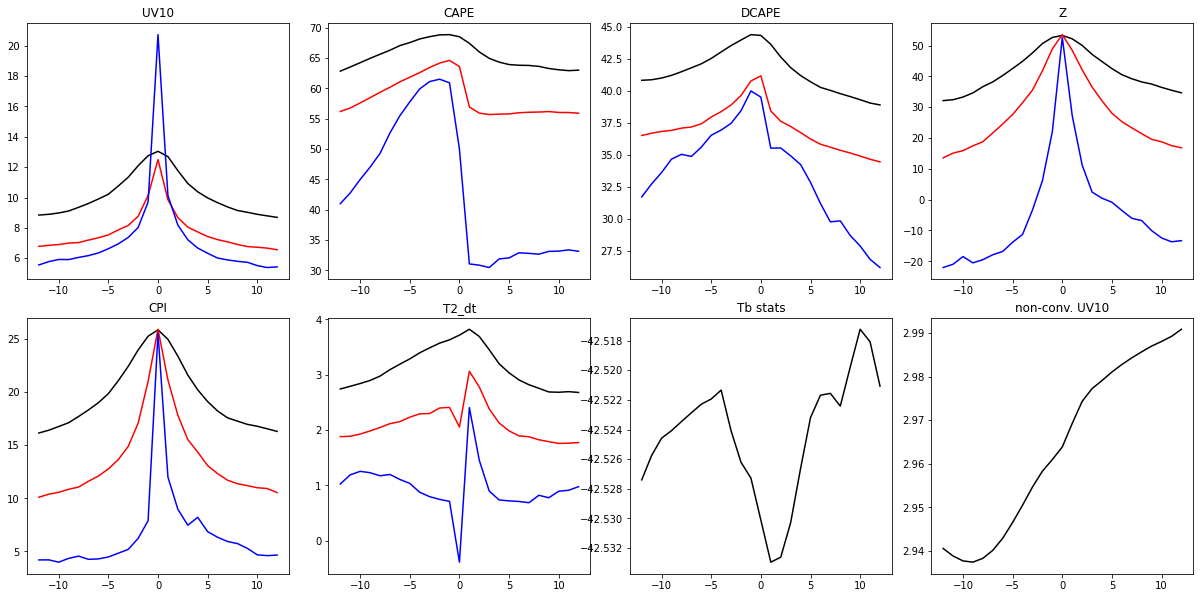

In [10]:
fig = plt.figure(figsize=(18,9))
gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.15, hspace=0.15)

pp = 100
ax = plt.subplot(gs1[0,0])
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,0,var_name.index('uv10')], axis=0), c='k')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,1,var_name.index('uv10')], axis=0), c='r')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,2,var_name.index('uv10')], axis=0), c='b')
plt.title('UV10')

ax = plt.subplot(gs1[0,1])
plt.plot(time_delta, np.nanmean((2*var_stats[:,:,pp,0,var_name.index('cape')])**0.5, axis=0), c='k')
plt.plot(time_delta, np.nanmean((2*var_stats[:,:,pp,1,var_name.index('cape')])**0.5, axis=0), c='r')
plt.plot(time_delta, np.nanmean((2*var_stats[:,:,pp,2,var_name.index('cape')])**0.5, axis=0), c='b')
plt.title('CAPE')

ax = plt.subplot(gs1[0,2])
plt.plot(time_delta, np.nanmean((2*var_stats[:,:,pp,0,var_name.index('dcape')])**0.5, axis=0), c='k')
plt.plot(time_delta, np.nanmean((2*var_stats[:,:,pp,1,var_name.index('dcape')])**0.5, axis=0), c='r')
plt.plot(time_delta, np.nanmean((2*var_stats[:,:,pp,2,var_name.index('dcape')])**0.5, axis=0), c='b')
plt.title('DCAPE')

ax = plt.subplot(gs1[0,3])
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,0,var_name.index('Z')], axis=0), c='k')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,1,var_name.index('Z')], axis=0), c='r')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,2,var_name.index('Z')], axis=0), c='b')
plt.title('Z')

ax = plt.subplot(gs1[1,0])
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,0,var_name.index('cpi')], axis=0), c='k')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,1,var_name.index('cpi')], axis=0), c='r')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,2,var_name.index('cpi')], axis=0), c='b')
plt.title('CPI')

ax = plt.subplot(gs1[1,1])
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,0,var_name.index('t2_dt')], axis=0), c='k')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,1,var_name.index('t2_dt')], axis=0), c='r')
plt.plot(time_delta, np.nanmean(var_stats[:,:,pp,2,var_name.index('t2_dt')], axis=0), c='b')
plt.title('T2_dt')

ax = plt.subplot(gs1[1,2])
plt.plot(time_delta, np.nanmean(var_stats[:,:,50,0,var_name.index('Tb')], axis=0)-273.15, c='k')
plt.title('Tb stats')

ax = plt.subplot(gs1[1,3])
plt.plot(time_delta, np.nanmean(non_convective_UV10[:,:,50], axis=0), c='k')
plt.title('non-conv. UV10')

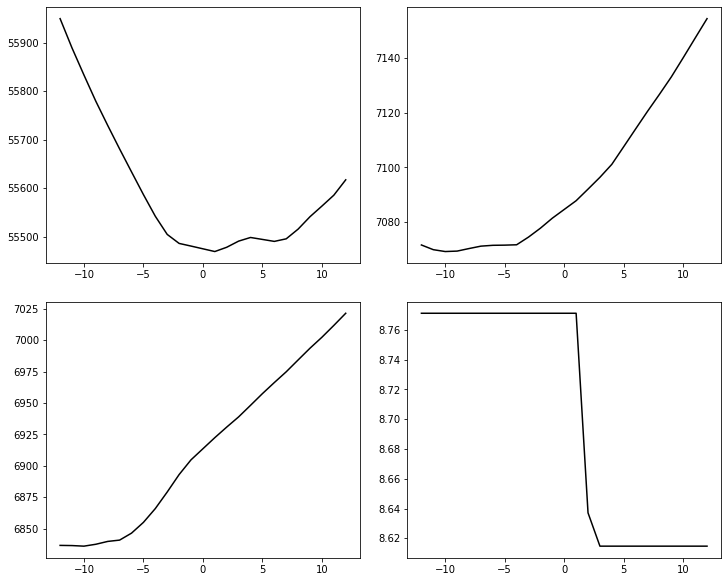

In [11]:
fig = plt.figure(figsize=(16,9))
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.15, hspace=0.15)

ax = plt.subplot(gs1[0,0])
plt.plot(time_delta, np.nanmean(area_coverages[:,:,0], axis=0)/1000**2, c='k')

ax = plt.subplot(gs1[0,1])
plt.plot(time_delta, np.nanmean(area_coverages[:,:,1], axis=0)/1000**2, c='k')

ax = plt.subplot(gs1[1,0])
plt.plot(time_delta, np.nanmean(area_coverages[:,:,2], axis=0)/1000**2, c='k')

ax = plt.subplot(gs1[1,1])
plt.plot(time_delta, np.nanmean(area_coverages[:,:,3], axis=0)/1000**2, c='k')

In [12]:
uv_mask.shape

(352, 360)

/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater_equal
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


IndexError: index 1436 is out of bounds for axis 0 with size 352

<Figure size 1152x648 with 0 Axes>

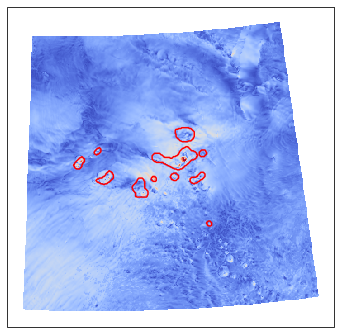

In [24]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import cartopy.feature as cf
import cartopy.crs as ccrs
ncfile = Dataset('/glade/u/home/prein/projects/2020_CONUS404/programs/plots/Domain/geo_em.d01.nc')
HGT_M = getvar(ncfile, "HGT_M")
cart_proj = get_cartopy(HGT_M)
ncid.close()

fig = plt.figure(figsize=(16,9))
gs1 = gridspec.GridSpec(2,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.15, hspace=0.15)


fig = plt.figure(figsize=(16,7))
gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.1, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.05, hspace=0.3)

tt = 720+716
z_act = np.copy(dbz[tt,:])
z_act[objects_tb[tt,:] == 0] = np.nan
z_mask = z_act >= 40
z_mask = scipy.ndimage.gaussian_filter(z_mask.astype('float'), 3) > 0.1

ax = plt.subplot(gs1[0,0], projection=cart_proj)
plt.pcolormesh(lon_wrf, lat_wrf, uv10[tt,:], vmin=0, vmax=15, cmap='coolwarm', transform=ccrs.PlateCarree())
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r', transform=ccrs.PlateCarree())
plt.contour(lon_wrf, lat_wrf, tb_mask[tt,:], [1], colors='w', transform=ccrs.PlateCarree())

ax.coastlines(zorder = 20)
ax.add_feature(cf.BORDERS, alpha=0.5, zorder = 20)
ax.add_feature(cf.STATES, lw=0.5, alpha=0.5, zorder = 20)


ax = plt.subplot(gs1[0,1])
dcape_conv = np.copy(dcape[tt-1,:,:])
dcape_conv[uv10_conv_mask[tt,:,:] == 0] = np.nan
plt.pcolormesh(dcape_conv, cmap='coolwarm', vmin=0, vmax=800)

# ax = plt.subplot(gs1[0,2])
# cape_conv = np.copy(cape[tt-1,:,:])
# cape_conv[uv10_conv_mask[tt,:,:] == 0] = np.nan
# plt.pcolormesh(cape_conv, cmap='coolwarm', vmin=0, vmax=2500)

# ax = plt.subplot(gs1[1,0])
# cpi_conv = np.copy(cpi[tt,:,:])
# cpi_conv[uv10_conv_mask[tt,:,:] == 0] = np.nan
# plt.pcolormesh(cpi_conv, cmap='coolwarm', vmin=0, vmax=20)

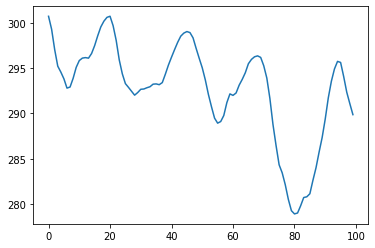

In [14]:
plt.plot(np.nanmean(Tb, axis=(1,2))[550:650])

In [15]:
np.argmax(np.nanmean(dbz, axis=(1,2)))

330

In [16]:
TimeHH[717+720+744]

Timestamp('2010-08-30 21:00:00', freq='H')

/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater_equal
  
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less_equal
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: No contour levels were found within the data range.
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: The following kwargs were not used by contour: 'lw'
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: No contour levels were found within the data range.
/glade/work/pre

        Plot map to: Selection_of_convective_regions_2010-08-30.jpg


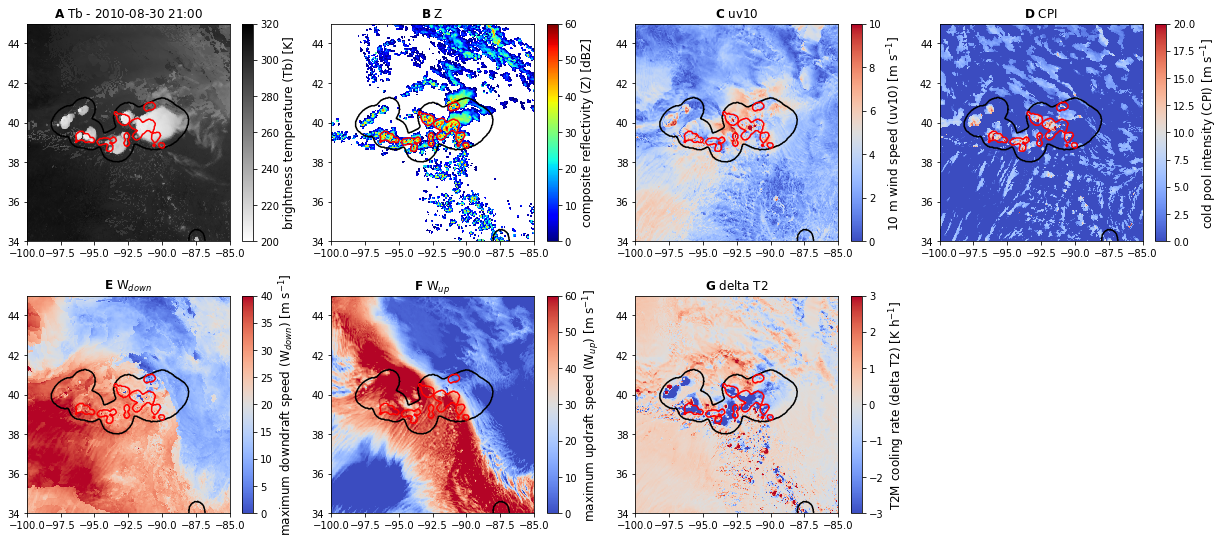

In [34]:
import string
rgsLableABC=list(string.ascii_uppercase)
fig = plt.figure(figsize=(18,8))
gs1 = gridspec.GridSpec(2,4)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.2, hspace=0.25)

tt = 717+720 #630+24

tb_mask = scipy.ndimage.gaussian_filter((Tb[tt,:,:] <= 241).astype('float'),5) > 0.01
z_act = np.copy(dbz[tt,:])
z_act[objects_tb[tt,:] == 0] = np.nan
z_mask = z_act >= 40
z_mask = scipy.ndimage.gaussian_filter(z_mask.astype('float'), 3) > 0.1

ax = plt.subplot(gs1[0,0])
dbz_act = np.copy(dbz[tt,:,:])
dbz_act[dbz_act <= 0] = None
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.pcolormesh(lon_wrf, lat_wrf, Tb[tt,:,:], cmap='gray_r',vmin=200,vmax=320)
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('brightness temperature (Tb) [K]', fontsize=12)
plt.title(r"$\bf{" + rgsLableABC[0] + " }$"+' Tb - '+str(TimeHH[717+720+744])[:16])

ax = plt.subplot(gs1[0,1])
dbz_act = np.copy(dbz[tt,:,:])
dbz_act[dbz_act <= 0] = None
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.pcolormesh(lon_wrf, lat_wrf, dbz_act, vmin=0, vmax=60, cmap='jet')
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('composite reflectivity (Z) [dBZ]', fontsize=12)
plt.title(r"$\bf{" + rgsLableABC[1] + " }$"+' Z')


ax = plt.subplot(gs1[0,2])
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.pcolormesh(lon_wrf, lat_wrf, uv10[tt,:,:], vmin=0, vmax=10, cmap='coolwarm')
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('10 m wind speed (uv10) [m s$^{-1}$]', fontsize=12)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.title(r"$\bf{" + rgsLableABC[2] + " }$"+' uv10')

ax = plt.subplot(gs1[0,3])
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.pcolormesh(lon_wrf, lat_wrf, cpi[tt,:,:], vmin=0, vmax=20, cmap='coolwarm')
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('cold pool intensity (CPI) [m s$^{-1}$]', fontsize=12)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.title(r"$\bf{" + rgsLableABC[3] + " }$"+' CPI')

ax = plt.subplot(gs1[1,0])
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.pcolormesh(lon_wrf, lat_wrf, (2*dcape[tt,:,:])**0.5, vmin=0, vmax=40, cmap='coolwarm')
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('maximum downdraft speed (W$_{down}$) [m s$^{-1}$]', fontsize=12)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.title(r"$\bf{" + rgsLableABC[4] + " }$"+' W$_{down}$')

ax = plt.subplot(gs1[1,1])
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.pcolormesh(lon_wrf, lat_wrf, (2*cape[tt-1,:,:])**0.5, vmin=0, vmax=60, cmap='coolwarm')
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('maximum updraft speed (W$_{up}$) [m s$^{-1}$]', fontsize=12)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.title(r"$\bf{" + rgsLableABC[5] + " }$"+' W$_{up}$')

ax = plt.subplot(gs1[1,2])
plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
plt.pcolormesh(lon_wrf, lat_wrf, t2[tt,:,:]-t2[tt-1,:,:], vmin=-3, vmax=3, cmap='coolwarm')
ax.set_xlim([-100,-85])
ax.set_ylim([34,45])
cbar = plt.colorbar()
cbar.set_label('T2M cooling rate (delta T2) [K h$^{-1}$]', fontsize=12)
plt.contour(lon_wrf, lat_wrf, z_mask[:,:], [1], colors='r')
plt.title(r"$\bf{" + rgsLableABC[6] + " }$"+' delta T2')

sPlotFile=''
sPlotName= 'Selection_of_convective_regions_'+str(TimeHH[717+720+744])[:10]+'.jpg'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print( '        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName, bbox_inches='tight', dpi=700)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater_equal
  after removing the cwd from sys.path.


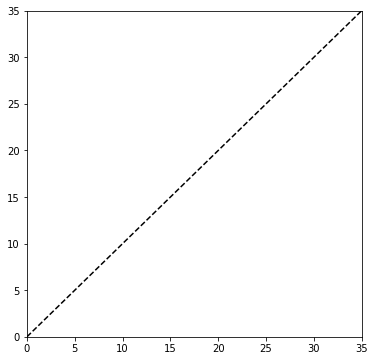

In [18]:
f, ax = plt.subplots(figsize=(6, 6))

dbz_th = 30
dbz_bin = dbz >= dbz_th

uv10_conv = uv10[dbz_bin == 1]
uv10_nonconv = uv10[dbz_bin == 0]
plt.scatter(np.percentile(uv10_nonconv, np.arange(0,100.1,0.1)),
                         np.percentile(uv10_conv, np.arange(0,100.1,0.1)))
plt.xlim([0,35])
plt.ylim([0,35])
# sns.kdeplot(uv10_nonconv, c='k', bw=1)
# sns.kdeplot(uv10_conv, c='r', bw=1)

plt.plot([0, 1], [0, 1], transform=ax.transAxes, c='k', ls='--')


/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater_equal
  from ipykernel import kernelapp as app
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  from ipykernel import kernelapp as app
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y ha

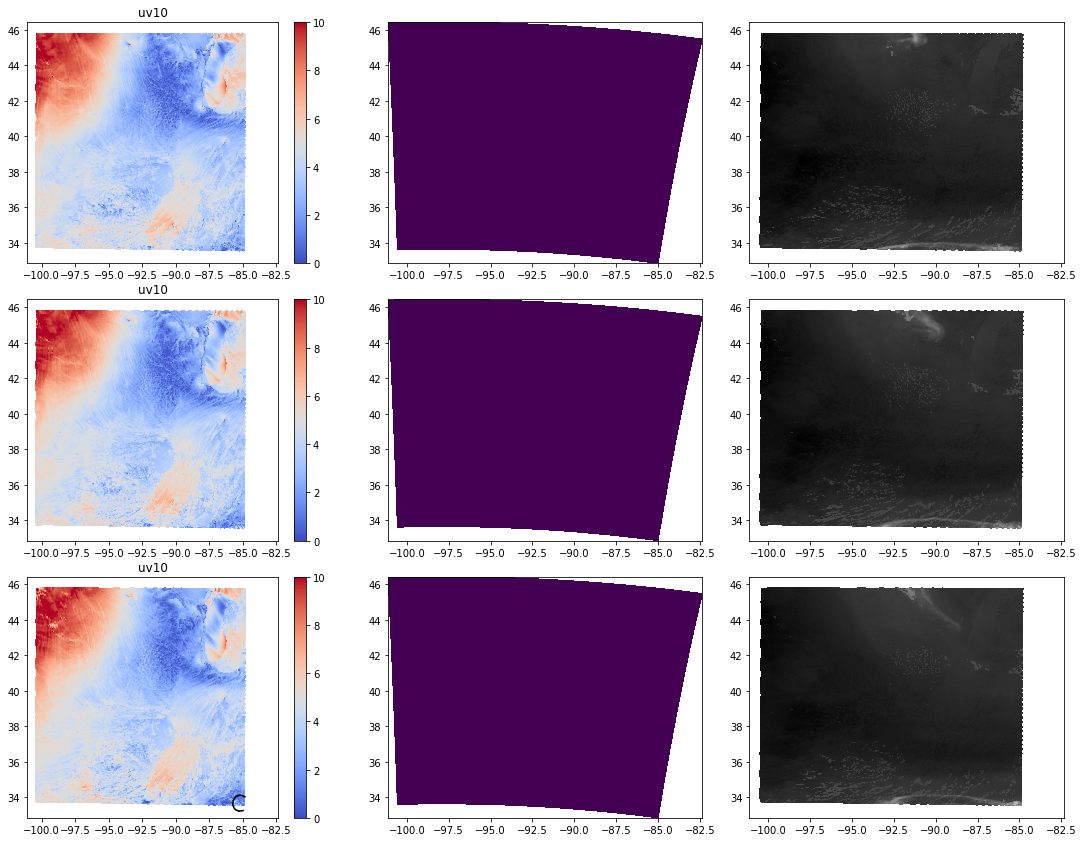

In [19]:
fig = plt.figure(figsize=(16,13))
gs1 = gridspec.GridSpec(3,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.15, hspace=0.15)

tt = 717 # 350

for hh in range(3):
    wind_conv = np.copy(uv10[tt+hh,:,:])
    tb_mask = scipy.ndimage.gaussian_filter((Tb[tt+hh,:,:] <= 241).astype('float'),5) > 0.01
    wind_conv[tb_mask[:,:] == 0] = np.nan

    ax = plt.subplot(gs1[hh,1])
    plt.pcolormesh(lon_wrf, lat_wrf, scipy.ndimage.gaussian_filter((wind_conv>= 7).astype('float'),3) > 0.1)

    ax = plt.subplot(gs1[hh,2])
    plt.pcolormesh(lon_wrf, lat_wrf, Tb[tt+hh,:,:], cmap='gray_r',vmin=200,vmax=320)

    ax = plt.subplot(gs1[hh,0])
    plt.pcolormesh(lon_wrf, lat_wrf, uv10[tt+hh,:,:], vmin=0, vmax=10, cmap='coolwarm')
    cbar = plt.colorbar()
    plt.contour(lon_wrf, lat_wrf, scipy.ndimage.gaussian_filter((wind_conv>= 7).astype('float'),3), [0.1], colors = 'k', alpha=0.5)
    plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
    plt.title('uv10')

/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less_equal
  # This is added back by InteractiveShellApp.init_path()
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  app.launch_new_instance()
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: No contour levels were found within the data range.
/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: The following kwargs were not used by contour: 'lw'
/glade/work/prein/PYTHON_CASPER_202212/lib/

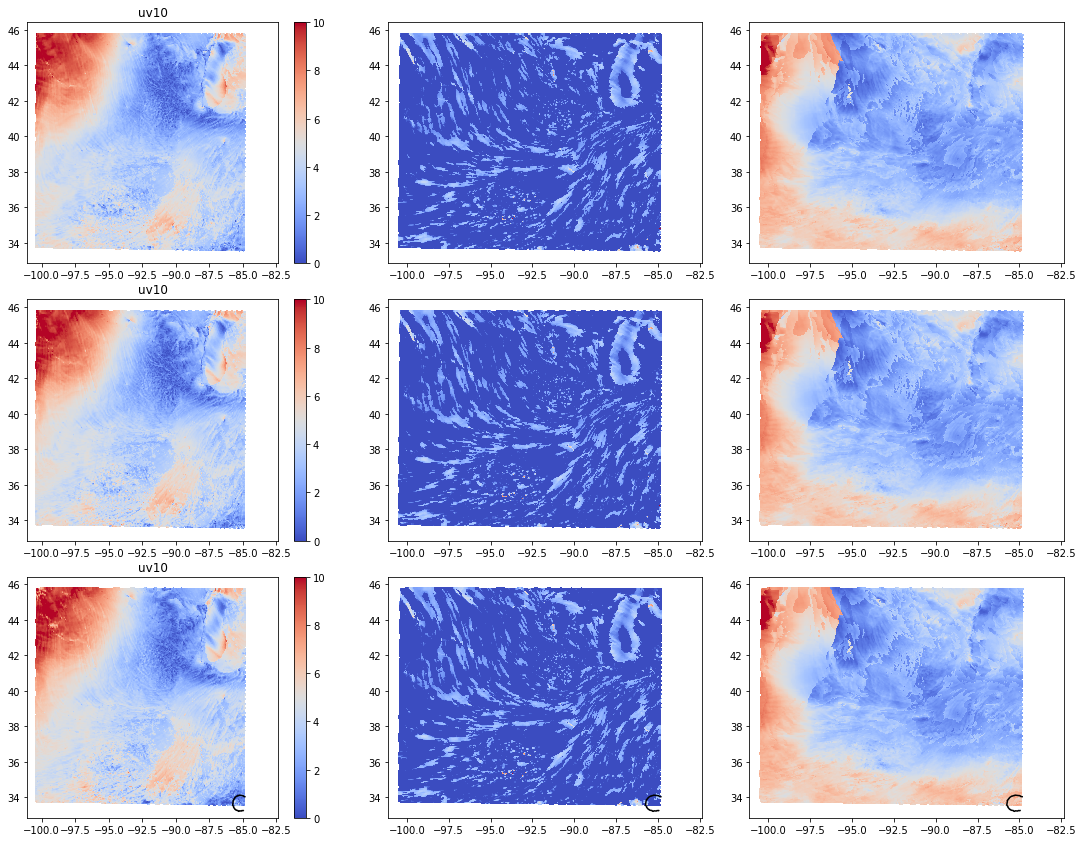

In [20]:
fig = plt.figure(figsize=(16,13))
gs1 = gridspec.GridSpec(3,3)
gs1.update(left=0.08, right=0.98,
   bottom=0.1, top=0.95,
   wspace=0.15, hspace=0.15)

tt = 717 # 350

for hh in range(3):
    wind_conv = np.copy(uv10[tt+hh,:,:])
    tb_mask = scipy.ndimage.gaussian_filter((Tb[tt+hh,:,:] <= 241).astype('float'),5) > 0.01
    wind_conv[tb_mask[:,:] == 0] = 0

    # Plot CPI
    ax = plt.subplot(gs1[hh,1])
    plt.pcolormesh(lon_wrf, lat_wrf, cpi[tt,:,:], vmin=0, vmax=20, cmap='coolwarm')
    plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)


    ax = plt.subplot(gs1[hh,2])
    plt.pcolormesh(lon_wrf, lat_wrf, (2*dcape[tt,:,:])**0.5, vmin=0, vmax=40, cmap='coolwarm')
    plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)

    ax = plt.subplot(gs1[hh,0])
    plt.pcolormesh(lon_wrf, lat_wrf, uv10[tt+hh,:,:], vmin=0, vmax=10, cmap='coolwarm')
    cbar = plt.colorbar()
    plt.contour(lon_wrf, lat_wrf, scipy.ndimage.gaussian_filter((wind_conv>= 7).astype('float'),3), [0.1], colors = 'k', alpha=0.5)
    plt.contour(lon_wrf, lat_wrf, tb_mask, [1], colors = 'k', alpha=1, lw=2)
    plt.title('uv10')

/glade/work/prein/PYTHON_CASPER_202212/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


NameError: name 'dbz_act' is not defined

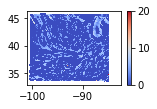

In [21]:
ax = plt.subplot(gs1[0,2])
plt.pcolormesh(lon_wrf, lat_wrf, cpi[tt,:,:], vmin=0, vmax=20, cmap='coolwarm')
cbar = plt.colorbar()
plt.contour(lon_wrf, lat_wrf, dbz_act, [20], colors = 'k', alpha=0.5)
plt.title('CPI')

In [22]:
plt.contourf(lon_wrf,lat_wrf, Boyancy[0,0,:,:], cmap='coolwarm', levels=np.linspace(-0.06,0.06,21), extend='both')

NameError: name 'Boyancy' is not defined